In [31]:
%matplotlib inline
import matplotlib.pyplot as plt


# import os
# import sys
# sys.path.append(os.path.dirname(os.getcwd())) # top-level of code

from collections import defaultdict
import random
import pickle
import numpy as np
import pandas as pd

from ortools.linear_solver import pywraplp

from covid_xprize.scoring.prescriptor_scoring import compute_pareto_set
from covid_xprize.scoring.prescriptor_scoring import compute_domination_df

from covid_xprize.standard_predictor.xprize_predictor import XPrizePredictor

In [2]:
NPI_COLS = ['C1',
            'C2',
            'C3',
            'C4',
            'C5',
            'C6',
            'C7',
            'C8',
            'H1',
            'H2',
            'H3',
            'H6']

In [3]:
NPI_COLS_NAMES = ['C1_School closing',
            'C2_Workplace closing',
            'C3_Cancel public events',
            'C4_Restrictions on gatherings',
            'C5_Close public transport',
            'C6_Stay at home requirements',
            'C7_Restrictions on internal movement',
            'C8_International travel controls',
            'H1_Public information campaigns',
            'H2_Testing policy',
            'H3_Contact tracing',
            'H6_Facial Coverings']

In [4]:
NPI_values = [[0,1,2,3],
             [0,1,2,3],
             [0,1,2],
             [0,1,2,3,4],
             [0,1,2],
             [0,1,2,3],
             [0,1,2],
             [0,1,2,3,4],
             [0,1,2],
             [0,1,2,3],
             [0,1,2],
             [0,1,2,3,4]]

In [5]:
col_names = ['PrescriptionIndex', 'CountryName', 'RegionName', 'Date'] + NPI_COLS_NAMES

In [6]:
country = 'Canada'
country_region = 'Canada_nan'
RegionName = ''

In [7]:
# case_weights_2 = d.read_csv('weights_7_past.csv', index_col=0)
case_weights_dict = {}
case_weights_dict['case_weights_1'] = pd.read_csv('weights.csv', index_col=0)
case_weights_dict['case_weights_7'] = pd.read_csv('weights_7.csv', index_col=0)
case_weights_dict['case_weights_7_past'] = pd.read_csv('weights_7_past.csv', index_col=0)

case_weights_names = ['case_weights_1', 'case_weights_7', 'case_weights_7_past']
num_case_weights = len(case_weights_names)

In [45]:
case_weights_dict['case_weights_1'][case_weights_dict['case_weights_1']['Country_Region'] == 'Canada_nan']

,Country_Region,IP,IP Val,impact
2346,Canada_nan,C1_School closing,1,-1.901214
2347,Canada_nan,C1_School closing,2,-3.654006
2348,Canada_nan,C1_School closing,3,-5.276531
2349,Canada_nan,C2_Workplace closing,1,-2.204706
2350,Canada_nan,C2_Workplace closing,2,-4.286983
2351,Canada_nan,C2_Workplace closing,3,-6.261813
2352,Canada_nan,C3_Cancel public events,1,-0.443481
2353,Canada_nan,C3_Cancel public events,2,-0.852238
2354,Canada_nan,C4_Restrictions on gatherings,1,-0.726733
2355,Canada_nan,C4_Restrictions on gatherings,2,-1.394435


In [8]:
# stringency weights

stringency_weight_df = pd.read_csv("covid_xprize/validation/data/uniform_random_costs.csv")
stringency_weight_tmp = stringency_weight_df[stringency_weight_df['CountryName'] == country][NPI_COLS_NAMES].to_numpy()[0]

# stringency_weight_tmp = [0.92,0.03,0.68,1.41,1.58,1.41,1.25,1.44,0.85,0.46,0.76,1.21]
stringency_weight_sum = 0
for i in range(len(NPI_COLS)):
    stringency_weight_sum +=  stringency_weight_tmp[i]*sum(NPI_values[i])

print(stringency_weight_tmp)
print(stringency_weight_sum)

# transform stringency to match level
stringency_weight = {}
for i in range(len(NPI_COLS)):
    tmp = []
    for j in range(len(NPI_values[i])):
        tmp.append((stringency_weight_tmp[i] * (NPI_values[i][j]))/stringency_weight_sum)
    stringency_weight[NPI_COLS[i]] = tmp
    
stringency_weight

[0.92 0.03 0.68 1.41 1.58 1.41 1.25 1.44 0.85 0.46 0.76 1.21]
72.88


{'C1': [0.0, 0.012623490669593854, 0.025246981339187707, 0.03787047200878156],
 'C2': [0.0, 0.000411635565312843, 0.000823271130625686, 0.001234906695938529],
 'C3': [0.0, 0.00933040614709111, 0.01866081229418222],
 'C4': [0.0,
  0.019346871569703623,
  0.038693743139407245,
  0.058040614709110865,
  0.07738748627881449],
 'C5': [0.0, 0.021679473106476402, 0.043358946212952804],
 'C6': [0.0, 0.019346871569703623, 0.038693743139407245, 0.058040614709110865],
 'C7': [0.0, 0.017151481888035128, 0.034302963776070255],
 'C8': [0.0,
  0.019758507135016465,
  0.03951701427003293,
  0.0592755214050494,
  0.07903402854006586],
 'H1': [0.0, 0.011663007683863887, 0.023326015367727774],
 'H2': [0.0, 0.006311745334796927, 0.012623490669593854, 0.01893523600439078],
 'H3': [0.0, 0.010428100987925357, 0.020856201975850714],
 'H6': [0.0,
  0.016602634467618,
  0.033205268935236,
  0.04980790340285401,
  0.066410537870472]}

In [9]:
# set global variables
# num_IP = 12 
data_url = 'covid_xprize/standard_predictor/data/OxCGRT_latest.csv'
OxCGRT_latest = pd.read_csv(data_url,
                                parse_dates=['Date'],
                                encoding="ISO-8859-1",
                                dtype={"RegionName": str,
                                       "RegionCode": str},
                                error_bad_lines=False)
OxCGRT_latest["GeoID"] = np.where(OxCGRT_latest["RegionName"].isnull(),
                                      OxCGRT_latest["CountryName"],
                                      OxCGRT_latest["CountryName"] + ' / ' + OxCGRT_latest["RegionName"])
OxCGRT_latest['NewCases'] = OxCGRT_latest.groupby('GeoID').ConfirmedCases.diff().fillna(0)
initial_day_cases = OxCGRT_latest[(OxCGRT_latest['CountryName'] == country) & (OxCGRT_latest['Date'] == '2020-07-31')
             & (OxCGRT_latest['Jurisdiction'] == 'NAT_TOTAL')]['NewCases'].iloc[0]
# OxCGRT_latest[(OxCGRT_latest['CountryName'] == 'Canada') & (OxCGRT_latest['Date'] == '2020-07-31')
#              & (OxCGRT_latest['Jurisdiction'] == 'NAT_TOTAL')]
initial_day_cases

604.0

In [46]:
def run_opt(previous_day_case):
    solver = pywraplp.Solver.CreateSolver('SCIP')
    
    # Create variables
    x = {}
    for i in range(len(NPI_COLS)):
        for j in range(len(NPI_values[i])):
            x[i, j] = solver.IntVar(0, 1, (NPI_COLS[i] + '_' + str(NPI_values[i][j])))
    
#     print('Number of variables =', solver.NumVariables())
    
    # Create contraint

    for i in range(len(NPI_COLS)):
        solver.Add(solver.Sum([x[i, j] for j in range(len(NPI_values[i]))]) == 1)
    
    # Create objective function

    objective_terms = []
    objective_terms.append((previous_day_case/initial_day_cases)) # scale to initial number of cases
    for i in range(len(NPI_COLS)): # case cost
        for j in range(len(NPI_values[i])):
            objective_terms.append(((case_weight[NPI_COLS[i]][j] * x[i,j]) * previous_day_case)/initial_day_cases)
    for i in range(len(NPI_COLS)): # stringency cost
        for j in range(len(NPI_values[i])):
            objective_terms.append(stringency_weight[NPI_COLS[i]][j] * x[i, j])
    solver.Minimize(solver.Sum(objective_terms))
    
    status = solver.Solve()
#     print(status)
    
    solution = []
    for i in range(len(NPI_COLS)): 
        for j in range(len(NPI_values[i])):
            if x[i,j].solution_value() > 0.5:
#                 print(x[i,j], ': ', x[i,j].solution_value())
                solution.append(j)
    
    print('Total cost = ', solver.Objective().Value(), '\n')
    
    return solution

In [11]:
final_results = pd.read_csv('final_results.csv')[:33]
final_results;

In [12]:
prescriptor_names = ['BlindGreedy', 'Random1', 'Random2', 'CCR_opt', 'CCR_opt_norm', 'CCR_opt_norm_1']

In [13]:
prescriptor_names

['BlindGreedy',
 'Random1',
 'Random2',
 'CCR_opt',
 'CCR_opt_norm',
 'CCR_opt_norm_1']

In [34]:
pd.read_csv(cur_ip_file_path)

,Unnamed: 0,PrescriptionIndex,CountryName,RegionName,Date,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H6_Facial Coverings
0,0,0,Canada,NaN,2020-08-05,3,3,2,4,2,3,2,4,2,3,2,4


In [36]:
# predictor = XPrizePredictor()

# predictor.predict(cur_start_date, cur_start_date, cur_ip_file_path)['PredictedDailyNewCases']

0    580.749623
Name: PredictedDailyNewCases, dtype: float64

In [39]:
# predictor.predict(cur_start_date, cur_start_date, cur_ip_file_path)['PredictedDailyNewCases'].values[0]

580.7496233285368

In [40]:
predictor = XPrizePredictor()

In [48]:
case_weight

{'C1': [0, -0.030262373889811164, -0.05737146342962217, -0.08180954538139307],
 'C2': [0, -0.03526483516559888, -0.06739642897719286, -0.09686296055393932],
 'C3': [0, -0.007691626139311898, -0.014717761016472769],
 'C4': [0,
  -0.012149244826580707,
  -0.02315687873849459,
  -0.03316665844023003,
  -0.04227856070453193],
 'C5': [0, -0.01888794715650942, -0.035442233999534785],
 'C6': [0, -0.010034429480361097, -0.0188828020499517, -0.026709230985192404],
 'C7': [0, -0.010749311071524225, -0.02063458783984721],
 'C8': [0,
  -0.014705200757741977,
  -0.027644141862422523,
  -0.039082753071184445,
  -0.049224074370413734],
 'H1': [0, -0.01852873902378673, -0.034569388433190865],
 'H2': [0, -0.020059996661035532, -0.03755952272339648, -0.05287982144327438],
 'H3': [0, -0.011979470548399141, -0.022474320909922865],
 'H6': [0,
  -0.006489571872073375,
  -0.012412715305160462,
  -0.017820519371419315,
  -0.02277954034843401]}

In [50]:
%%time

ip_file_path = 'test_prescriptions/'
preds_file_path = 'test_predictions/'

# Run predictor
# !python covid_xprize/standard_predictor/predict.py -s $START_DATE -e $END_DATE -ip $ip_file_path -o $preds_file_path
import datetime
START_DATE = np.datetime64("2020-08-01")
END_DATE = np.datetime64("2020-08-05")
day_count = 5

previous_day_cases = initial_day_cases
for w in case_weights_names:
    print('generating results for ' + w)
    cur_case_weight = case_weights_dict[w][case_weights_dict[w]['Country_Region'] == country_region]['impact'].values
    case_weight = {}
    index = 0
    for i in range(len(NPI_COLS)):
        tmp = [0]
        for j in range(len(NPI_values[i]) - 1):
            tmp.append(cur_case_weight[index]/100)
            index += 1
        case_weight[NPI_COLS[i]] = tmp
    
    prescriptions_total_df = pd.DataFrame(columns = col_names)
    predictions_total = []
    # prescriptions_total = []

    for i in range(day_count):
        cur_start_date = START_DATE + np.timedelta64(i,'D')
        cur_end_date = START_DATE + np.timedelta64(i,'D')
        cur_ip_file_path = ip_file_path + 'prescriptions_initial_' + w + '_'+ str(cur_start_date) + '.csv'
        cur_preds_file_path = preds_file_path + 'predictions_initial' + w + '_' + str(cur_start_date) + '.csv'

        ip_solution = run_opt(previous_day_cases)
        prescriptions = [0] + [country] + [RegionName] + [str(cur_start_date)] + ip_solution
        prescriptions_df = pd.DataFrame(columns=col_names)
        prescriptions_df.loc[0] = prescriptions
        prescriptions_total_df.loc[i] = prescriptions

        prescriptions_df.to_csv(cur_ip_file_path)
        
        previous_day_cases = predictor.predict(cur_start_date, cur_start_date, cur_ip_file_path)['PredictedDailyNewCases'].values[0]

#         !python covid_xprize/standard_predictor/predict.py -s $cur_start_date -e $cur_start_date -ip $cur_ip_file_path -o $cur_preds_file_path

#         predictions = pd.read_csv(cur_preds_file_path)
#         previous_day_cases = predictions.loc[0]['PredictedDailyNewCases']
        predictions_total.append(previous_day_cases)

    prescriptions_total_df[NPI_COLS_NAMES] = prescriptions_total_df[NPI_COLS_NAMES].astype(int)

    avg_pres = prescriptions_total_df.groupby(['CountryName', 
                                       'RegionName', 
                                       'PrescriptionIndex'], dropna=False).mean().reset_index().loc[0][NPI_COLS_NAMES].values
    tot_stringency_cost = (stringency_weight_tmp * avg_pres).sum()
    print(tot_stringency_cost)

    avg_new_cases = np.mean(predictions_total)
    print(avg_new_cases, '\n', '\n', '\n')
    
    pres_name = 'CCR_opt_norm_initial_' + w
    final_results.loc[len(final_results)] = [country, np.nan, 0, avg_new_cases, tot_stringency_cost, pres_name]
    prescriptor_names += [pres_name]
    
    break

generating results for case_weights_1
Total cost =  0.9104576769083117 

Total cost =  0.7716556333114803 

Total cost =  0.6996530370775927 

Total cost =  1.1984164308179097 

Total cost =  0.7358736712439149 

4.386
569.6927772345185 
 
 

CPU times: user 263 ms, sys: 12 ms, total: 275 ms
Wall time: 275 ms


In [17]:
w = 'max'

for i in range(day_count):
    cur_start_date = START_DATE + np.timedelta64(i,'D')
    cur_end_date = START_DATE + np.timedelta64(i,'D')
    cur_ip_file_path = ip_file_path + 'prescriptions_initial_' + w + '_'+ str(cur_start_date) + '.csv'
    cur_preds_file_path = preds_file_path + 'predictions_initial' + w + '_' + str(cur_start_date) + '.csv'

    ip_solution = [max(a) for a in NPI_values]
    prescriptions = [0] + [country] + [RegionName] + [str(cur_start_date)] + ip_solution
    prescriptions_df = pd.DataFrame(columns=col_names)
    prescriptions_df.loc[0] = prescriptions
    prescriptions_total_df.loc[i] = prescriptions

    prescriptions_df.to_csv(cur_ip_file_path)

    !python covid_xprize/standard_predictor/predict.py -s $cur_start_date -e $cur_start_date -ip $cur_ip_file_path -o $cur_preds_file_path

    predictions = pd.read_csv(cur_preds_file_path)
    previous_day_cases = predictions.loc[0]['PredictedDailyNewCases']
    predictions_total.append(previous_day_cases)

prescriptions_total_df[NPI_COLS_NAMES] = prescriptions_total_df[NPI_COLS_NAMES].astype(int)

avg_pres = prescriptions_total_df.groupby(['CountryName', 
                                   'RegionName', 
                                   'PrescriptionIndex'], dropna=False).mean().reset_index().loc[0][NPI_COLS_NAMES].values
tot_stringency_cost = (stringency_weight_tmp * avg_pres).sum()
print(tot_stringency_cost)

avg_new_cases = np.mean(predictions_total)
print(avg_new_cases, '\n', '\n', '\n')

pres_name = 'CCR_opt_norm_initial_max'
final_results = final_results.reset_index(drop=True)
final_results.loc[len(final_results)] = [country, np.nan, 0, avg_new_cases, tot_stringency_cost, pres_name]
prescriptor_names += [pres_name]

Generating predictions from 2020-08-01 to 2020-08-01...
Saved predictions to test_predictions/predictions_initialmax_2020-08-01.csv
Done!
Generating predictions from 2020-08-02 to 2020-08-02...
Saved predictions to test_predictions/predictions_initialmax_2020-08-02.csv
Done!
Generating predictions from 2020-08-03 to 2020-08-03...
Saved predictions to test_predictions/predictions_initialmax_2020-08-03.csv
Done!
Generating predictions from 2020-08-04 to 2020-08-04...
Saved predictions to test_predictions/predictions_initialmax_2020-08-04.csv
Done!
Generating predictions from 2020-08-05 to 2020-08-05...
Saved predictions to test_predictions/predictions_initialmax_2020-08-05.csv
Done!
34.94
559.2563149457989 
 
 



In [23]:
def plot_pareto_curve(objective1_list, objective2_list):
    """
    Plot the pareto curve given the objective values for a set of solutions.
    This curve indicates the area dominated by the solution set, i.e., 
    every point up and to the right is dominated.
    """
    
    # Compute pareto set from full solution set.
    objective1_pareto, objective2_pareto = compute_pareto_set(objective1_list, 
                                                              objective2_list)
    
    # Sort by first objective.
    objective1_pareto, objective2_pareto = list(zip(*sorted(zip(objective1_pareto,
                                                                objective2_pareto))))
    
    # Compute the coordinates to plot.
    xs = []
    ys = []
    
    xs.append(objective1_pareto[0])
    ys.append(objective2_pareto[0])
    
    for i in range(0, len(objective1_pareto)-1):
        
        # Add intermediate point between successive solutions
        xs.append(objective1_pareto[i+1])
        ys.append(objective2_pareto[i])
        
        # Add next solution on front
        xs.append(objective1_pareto[i+1])
        ys.append(objective2_pareto[i+1])
        
    plt.plot(xs, ys)

In [24]:
# heuristics_results_all_country = pd.read_csv('heuristics_results_all_country.csv')

In [25]:
# plot_df = heuristics_results_all_country[(heuristics_results_all_country['CountryName'] == country) & (heuristics_results_all_country['RegionName'].isna())]

In [26]:
# final_results = plot_df.append(final_results)

In [27]:
prescriptor_names

['BlindGreedy',
 'Random1',
 'Random2',
 'CCR_opt',
 'CCR_opt_norm',
 'CCR_opt_norm_1',
 'CCR_opt_norm_initial_case_weights_1',
 'CCR_opt_norm_initial_case_weights_7',
 'CCR_opt_norm_initial_case_weights_7_past',
 'CCR_opt_norm_initial_max']

In [43]:
final_results

,CountryName,RegionName,PrescriptionIndex,PredictedDailyNewCases,Stringency,PrescriptorName
0,Canada,NaN,0,658.183601,0.090,BlindGreedy
1,Canada,NaN,1,644.066759,1.470,BlindGreedy
2,Canada,NaN,2,641.067334,2.830,BlindGreedy
3,Canada,NaN,3,636.993394,4.350,BlindGreedy
4,Canada,NaN,4,631.548111,6.050,BlindGreedy
5,Canada,NaN,5,614.952582,8.810,BlindGreedy
6,Canada,NaN,6,612.095606,13.650,BlindGreedy
7,Canada,NaN,7,609.669943,16.150,BlindGreedy
8,Canada,NaN,8,606.054774,21.790,BlindGreedy
9,Canada,NaN,9,604.238894,26.020,BlindGreedy


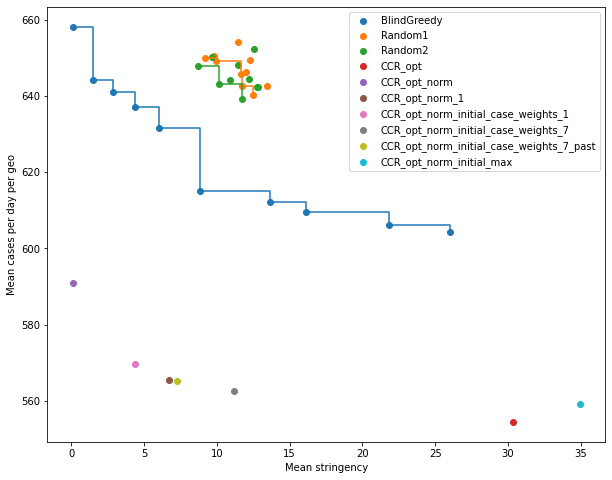

In [28]:
# Plot overall stringency and cases of each prescription
plt.figure(figsize=(10,8))
for prescriptor_name in prescriptor_names:
    pdf = final_results[final_results['PrescriptorName'] == prescriptor_name]
    overall_pdf = pdf.groupby('PrescriptionIndex').mean().reset_index()
    plt.scatter(overall_pdf['Stringency'],
                overall_pdf['PredictedDailyNewCases'], 
                label=prescriptor_name)
    plot_pareto_curve(list(overall_pdf['Stringency']),
                      list(overall_pdf['PredictedDailyNewCases']))
plt.xlabel('Mean stringency')
plt.ylabel('Mean cases per day per geo')
plt.legend()
plt.show()

In [29]:
ddf = compute_domination_df(final_results)
# Get number of dominated prescriptions for each submission. This is the "Domination Count"
ddf.groupby('DominatingName').count().sort_values('DominatedIndex', ascending=False)['DominatedIndex']

Computing domination for Canada nan


DominatingName
CCR_opt_norm                                29
CCR_opt_norm_initial_case_weights_1         26
CCR_opt_norm_1                              25
CCR_opt_norm_initial_case_weights_7_past    25
BlindGreedy                                 20
CCR_opt_norm_initial_case_weights_7         17
Random2                                      9
Random1                                      5
CCR_opt                                      1
Name: DominatedIndex, dtype: int64